## PRAKTIKUM 2


--- Experiment: n_points=1000, dim=2, metric=L2 ---
Exact NN (Flat) indices: [[112 535 777]]
Exact NN distances: [[2.1161813e-05 1.3761134e-03 2.3510854e-03]]
Waktu Exact: 0.00015497207641601562
IVF+PQ indices: [[112 535 777]]
IVF+PQ distances: [[1.6702339e-05 1.3291128e-03 2.3584329e-03]]
Waktu IVF+PQ: 4.9114227294921875e-05


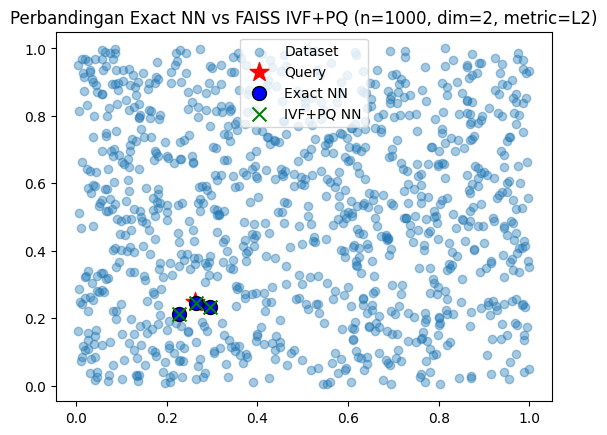


--- Experiment: n_points=1000, dim=2, metric=IP ---
Exact NN (Flat) indices: [[249 712 598]]
Exact NN distances: [[0.49857783 0.4965706  0.49405992]]
Waktu Exact: 4.601478576660156e-05
IVF+PQ indices: [[112 535 777]]
IVF+PQ distances: [[1.6702339e-05 1.3291128e-03 2.3584329e-03]]
Waktu IVF+PQ: 5.173683166503906e-05


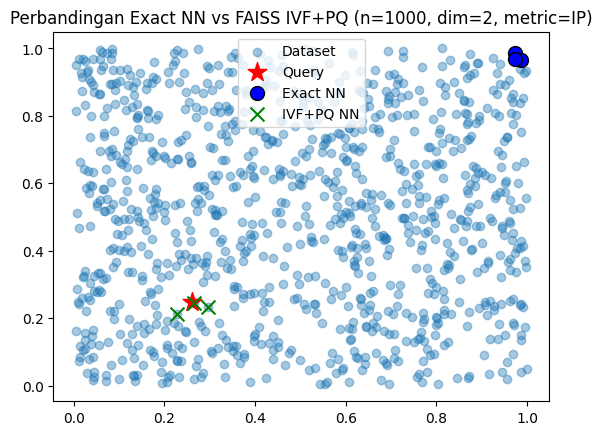


--- Experiment: n_points=1000, dim=5, metric=L2 ---
Exact NN (Flat) indices: [[988 780  27]]
Exact NN distances: [[0.01057143 0.0225298  0.04096785]]
Waktu Exact: 6.270408630371094e-05
IVF+PQ indices: [[988 780  27]]
IVF+PQ distances: [[0.01058318 0.0225963  0.04078479]]
Waktu IVF+PQ: 7.987022399902344e-05

--- Experiment: n_points=1000, dim=5, metric=IP ---
Exact NN (Flat) indices: [[210 106  49]]
Exact NN distances: [[2.536652  2.5025609 2.4636436]]
Waktu Exact: 2.7894973754882812e-05
IVF+PQ indices: [[988 780  27]]
IVF+PQ distances: [[0.01058318 0.0225963  0.04078479]]
Waktu IVF+PQ: 6.866455078125e-05

--- Experiment: n_points=1000000, dim=2, metric=L2 ---
Exact NN (Flat) indices: [[132774 119034 511191]]
Exact NN distances: [[1.2678578e-07 3.3845731e-07 4.1168511e-07]]
Waktu Exact: 0.005404472351074219
IVF+PQ indices: [[119034 132774 410129]]
IVF+PQ distances: [[1.6437843e-07 2.5378540e-07 2.5378540e-07]]
Waktu IVF+PQ: 0.0013518333435058594


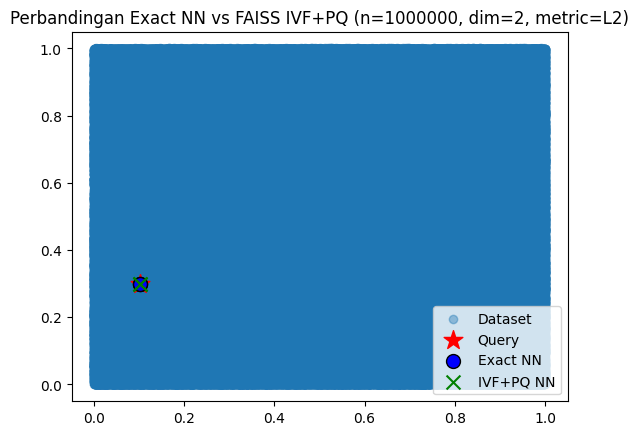


--- Experiment: n_points=1000000, dim=2, metric=IP ---
Exact NN (Flat) indices: [[489250 265642 659640]]
Exact NN distances: [[0.3998675  0.3998152  0.39964792]]
Waktu Exact: 0.00581669807434082
IVF+PQ indices: [[119034 132774 410129]]
IVF+PQ distances: [[1.6437843e-07 2.5378540e-07 2.5378540e-07]]
Waktu IVF+PQ: 0.0013620853424072266


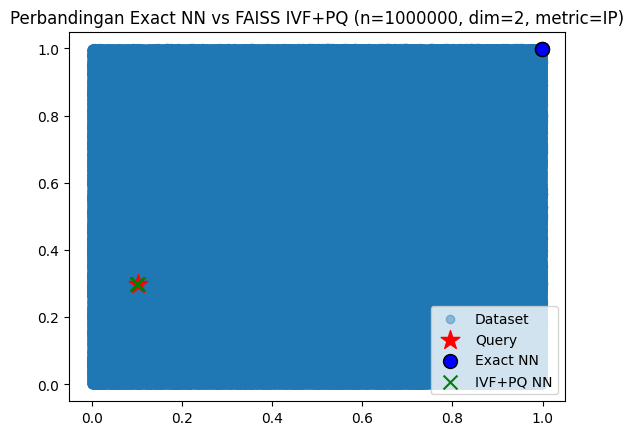


--- Experiment: n_points=1000000, dim=5, metric=L2 ---
Exact NN (Flat) indices: [[901095 495168 561017]]
Exact NN distances: [[0.00151859 0.00221511 0.00223645]]
Waktu Exact: 0.006169795989990234
IVF+PQ indices: [[901095 495168 561017]]
IVF+PQ distances: [[0.00143466 0.00220674 0.00234369]]
Waktu IVF+PQ: 0.0017275810241699219

--- Experiment: n_points=1000000, dim=5, metric=IP ---
Exact NN (Flat) indices: [[958577 238618 509273]]
Exact NN distances: [[2.701954 2.696338 2.681728]]
Waktu Exact: 0.0067980289459228516
IVF+PQ indices: [[901095 495168 561017]]
IVF+PQ distances: [[0.00143466 0.00220674 0.00234369]]
Waktu IVF+PQ: 0.001898050308227539


In [ ]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import time

# Function to run FAISS experiment
def run_faiss_experiment(n_points, dim, metric_type):
    np.random.seed(42)
    X = np.random.rand(n_points, dim).astype('float32')
    query = np.random.rand(1, dim).astype('float32')

    print(f"\n--- Experiment: n_points={n_points}, dim={dim}, metric={metric_type} ---")

    # Exact NN with IndexFlat
    if metric_type == 'L2':
        index_flat = faiss.IndexFlatL2(dim)
    elif metric_type == 'IP':
        index_flat = faiss.IndexFlatIP(dim)
    else:
        raise ValueError("Unsupported metric type")

    index_flat.add(X)

    start = time.time()
    D_flat, I_flat = index_flat.search(query, 3)
    end = time.time()
    time_flat = end - start

    print("Exact NN (Flat) indices:", I_flat)
    print("Exact NN distances:", D_flat)
    print("Waktu Exact:", time_flat)

    # IVF + PQ (Approximate)
    nlist = 10 if n_points < 100000 else 100 # Adjust nlist based on dataset size
    m = dim if dim <= 8 else 8 # Subvectors for PQ, max 8
    quantizer = faiss.IndexFlatL2(dim)

    if metric_type == 'L2':
        index_ivfpq = faiss.IndexIVFPQ(quantizer, dim, nlist, m, 8)
    elif metric_type == 'IP':
         index_ivfpq = faiss.IndexIVFPQ(quantizer, dim, nlist, m, 8) # Note: IVF+PQ uses L2 for clustering regardless of query metric

    index_ivfpq.train(X)
    index_ivfpq.add(X)

    # Set number of probes for IVF search (trade-off speed vs accuracy)
    index_ivfpq.nprobe = 5 if n_points < 100000 else 20

    start = time.time()
    D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
    end = time.time()
    time_ivfpq = end - start

    print("IVF+PQ indices:", I_ivfpq)
    print("IVF+PQ distances:", D_ivfpq)
    print("Waktu IVF+PQ:", time_ivfpq)

    # Visualisasi (only for 2D data)
    if dim == 2:
        plt.figure()
        plt.scatter(X[:,0], X[:,1], alpha=0.4, label="Dataset")
        plt.scatter(query[:,0], query[:,1], c='red', marker='*', s=200, label="Query")

        # Tetangga dari Flat
        plt.scatter(X[I_flat[0],0], X[I_flat[0],1], c='blue', s=100, edgecolor='k', label="Exact NN")

        # Tetangga dari IVF+PQ
        plt.scatter(X[I_ivfpq[0],0], X[I_ivfpq[0],1], c='green', marker='x', s=100, label="IVF+PQ NN")

        plt.legend()
        plt.title(f"Perbandingan Exact NN vs FAISS IVF+PQ (n={n_points}, dim={dim}, metric={metric_type})")
        plt.show()


# Run experiments
# Experiment 1: 1000 points, 2D, L2
run_faiss_experiment(1000, 2, 'L2')

# Experiment 2: 1000 points, 2D, IP
run_faiss_experiment(1000, 2, 'IP')

# Experiment 3: 1000 points, 5D, L2
run_faiss_experiment(1000, 5, 'L2')

# Experiment 4: 1000 points, 5D, IP
run_faiss_experiment(1000, 5, 'IP')

# Experiment 5: 1 million points, 2D, L2
run_faiss_experiment(1000000, 2, 'L2')

# Experiment 6: 1 million points, 2D, IP
run_faiss_experiment(1000000, 2, 'IP')

# Experiment 7: 1 million points, 5D, L2
run_faiss_experiment(1000000, 5, 'L2')

# Experiment 8: 1 million points, 5D, IP
run_faiss_experiment(1000000, 5, 'IP')